# 1. Исследовательский анализ данных

In [1]:
# < Перенесите сюда исследовательский анализ данных >
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense,AvgPool2D,GlobalAveragePooling2D
import matplotlib.pyplot as plt
import numpy as np 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
labels.shape

(7591, 2)

Всего 7591 картинка лиц.

Text(0.5, 1.0, 'Распределение картинок по возрасту')

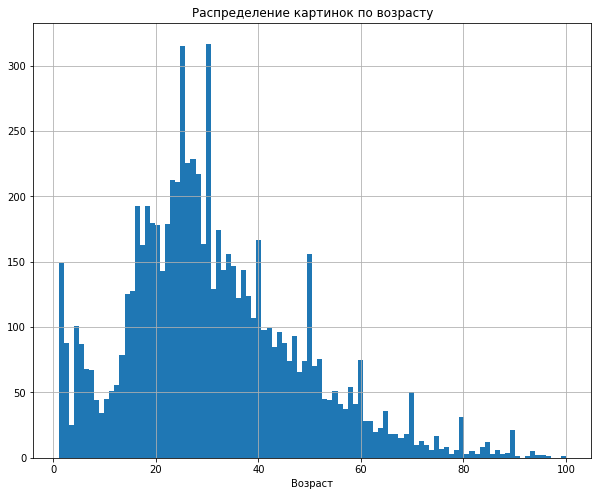

In [4]:
plt.figure(figsize=(10,8))
labels['real_age'].hist(bins=100,range=(1,100))
plt.xlabel('Возраст')
plt.title('Распределение картинок по возрасту')

Видно, что распределение не нормальное. Есть два пика. Распределение скошено в право. Больше всего представлено фотографий людей в возрасте от 20 до 30 лет.

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [6]:
features,target=next(train_gen_flow)

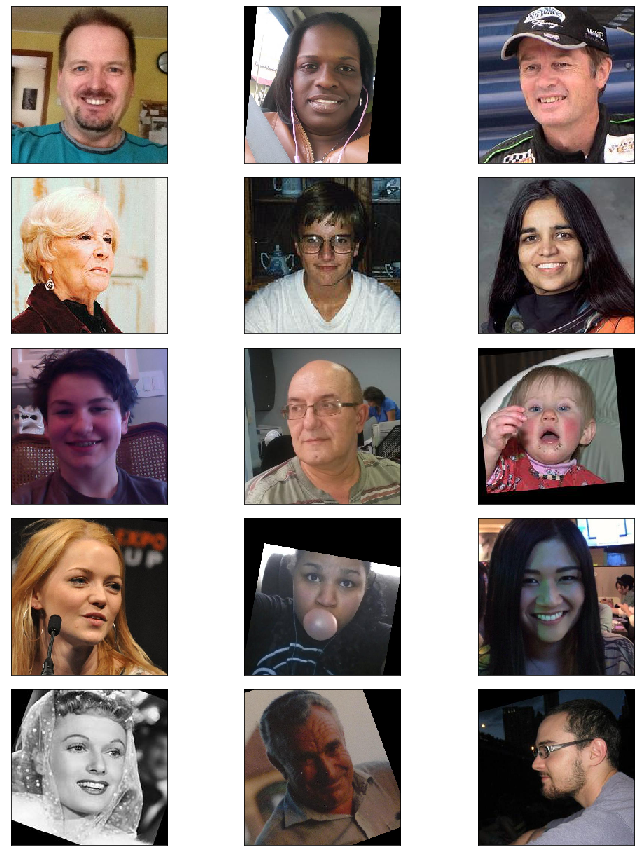

In [7]:
fig = plt.figure(figsize=(12,12))
for i in range(15):
    fig.add_subplot(5, 3, i+1)
    plt.imshow(features[i])
    # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Вывод: По данным исследования распределения по возрасту можно отметить, что модель хорошо обучится на картинках с возрастом от 20 до 30. Они приедставлены в большом объеме. По другим возрастам количество фоторгафий уменьшается. На них модель может чаще ошибаться.



# 2. Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

# < скопируйте код сюда >

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

# < скопируйте результат вывода на экран сюда >


Train for 356 steps, validate for 119 steps
Epoch 1/20
2020-06-02 19:40:48.008967: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-06-02 19:40:48.313601: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 51s - loss: 198.1647 - mae: 10.7148 - val_loss: 469.6664 - val_mae: 16.5876
Epoch 2/20
356/356 - 42s - loss: 128.5371 - mae: 8.6859 - val_loss: 259.9959 - val_mae: 12.0775
Epoch 3/20
356/356 - 41s - loss: 104.1180 - mae: 7.7927 - val_loss: 112.3774 - val_mae: 8.1556
Epoch 4/20
356/356 - 41s - loss: 89.1268 - mae: 7.2073 - val_loss: 268.4862 - val_mae: 12.2468
Epoch 5/20
356/356 - 41s - loss: 73.9540 - mae: 6.6025 - val_loss: 188.1514 - val_mae: 10.2307
Epoch 6/20
356/356 - 41s - loss: 67.1590 - mae: 6.2711 - val_loss: 125.5046 - val_mae: 8.4501
Epoch 7/20
356/356 - 41s - loss: 56.8140 - mae: 5.7757 - val_loss: 92.7534 - val_mae: 7.3068
Epoch 8/20
356/356 - 41s - loss: 48.5138 - mae: 5.3722 - val_loss: 92.8662 - val_mae: 7.1634
Epoch 9/20
356/356 - 42s - loss: 38.3648 - mae: 4.7784 - val_loss: 99.8112 - val_mae: 7.7086
Epoch 10/20
356/356 - 41s - loss: 37.5012 - mae: 4.7045 - val_loss: 95.2603 - val_mae: 7.4608
Epoch 11/20
356/356 - 42s - loss: 30.1417 - mae: 4.2713 - val_loss: 86.5627 - val_mae: 6.9568
Epoch 12/20
356/356 - 41s - loss: 26.1762 - mae: 3.9443 - val_loss: 90.1337 - val_mae: 7.1907
Epoch 13/20
356/356 - 41s - loss: 27.0887 - mae: 4.0229 - val_loss: 103.0476 - val_mae: 7.4912
Epoch 14/20
356/356 - 42s - loss: 24.3458 - mae: 3.8174 - val_loss: 78.7472 - val_mae: 6.6914
Epoch 15/20
356/356 - 41s - loss: 22.4094 - mae: 3.6307 - val_loss: 84.4656 - val_mae: 6.8786
Epoch 16/20
356/356 - 41s - loss: 19.8699 - mae: 3.4273 - val_loss: 104.8580 - val_mae: 7.3816
Epoch 17/20
356/356 - 42s - loss: 19.2096 - mae: 3.3649 - val_loss: 83.3470 - val_mae: 6.9820
Epoch 18/20
356/356 - 42s - loss: 18.5757 - mae: 3.3360 - val_loss: 81.4584 - val_mae: 6.9704
Epoch 19/20
356/356 - 41s - loss: 17.0264 - mae: 3.1599 - val_loss: 94.0446 - val_mae: 7.5723
Epoch 20/20
356/356 - 41s - loss: 15.6271 - mae: 3.0257 - val_loss: 78.0421 - val_mae: 6.6640
WARNING:tensorflow:sample_weight modes were coerced from
  ...
 
119/119 - 10s - loss: 78.0421 - mae: 6.6640
Test MAE: 6.6640
# < длинные строки со скачиванием модели можно удалить >

```

# 3. Анализ обученной модели

Для анализа возраста людей по фотографии была использована CCN ResNet50. Было задано 20 эпох и функция оптимизации для нахождения минимума Adam с шагом lr=0.0005. По итогам анализа мы получили значение метрики mean absolute error для обучающей и для валидационной выборки. Значение mae для обучающей получилось 3.0257, а для валидационной mae получилось 6.664. Модель немного переобучилась. Но разница в 3 года думаю не значительным переобучением и могу сказать, что модель предсказывает хорошо.